## Αναγνώριση Προτύπων

### 3ο εργαστήριο

### Αριστοτέλης-Γεώργιος Συμπέθερος  Α.Μ.:03116005
### Σάββας Σιφναίος Α.Μ.:03116080 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models-trained/fused_beat_rnn_32_ep_400_lr_001
/kaggle/input/models-trained/mel_overfitt
/kaggle/input/models-trained/chroma_beat_rnn_32_ep_400_lr_001
/kaggle/input/models-trained/mel_rnn_32_ep_400_lr_001
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/6459.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/7450.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/4465.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/6846.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/7469.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/4291.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_bea

### Βήμα 1

### (α)

In [2]:
import re
#Get all labels
f = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt', "r")
labels=list(f)
labels=[ re.split(r'\t+', i.rstrip('\t')) for i in labels]
labels=[[i[0],i[1].split('\n')[0]] for i in labels]

In [3]:
#Get 2 Random Samples from dataset (which are note the same music type)
spec_1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/1042.fused.full.npy')
spec_2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/115357.fused.full.npy')



In [4]:
print(spec_1.shape)  # (frequencies x time steps)
print(spec_2.shape)  # (frequencies x time steps)
lbl_1=[i [1] for i in labels if i[0]=="1042.fused.full.npy.gz"][0]
lbl_2=[i [1] for i in labels if i[0]=="115357.fused.full.npy.gz"][0]

print(f"Sample 1 is of type: {lbl_1}")
print(f"Sample 2 is of type: {lbl_2}")

(140, 1293)
(140, 1293)
Sample 1 is of type: Blues
Sample 2 is of type: Chiptune


In [5]:
#Get mel (and chroma for (c)) 
mel_1, chroma_1 = spec_1[:128], spec_1[128:]
mel_2, chroma_2 = spec_2[:128], spec_2[128:]

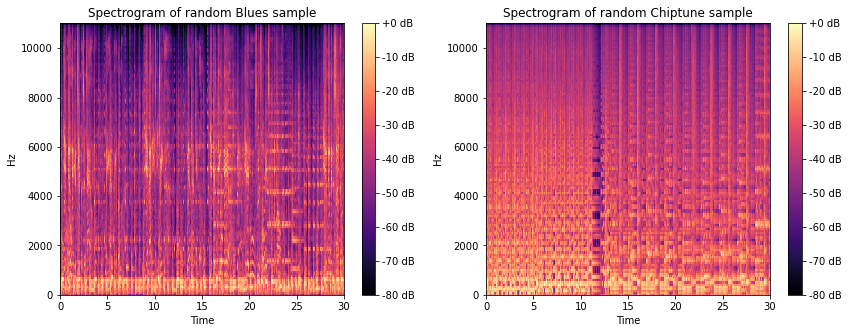

In [6]:
# Plot the spectrogram
import librosa.display
import matplotlib.pyplot as plt


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(mel_1, x_axis='time', y_axis='linear', ax=ax1)
ax1.set(title=f'Spectrogram of random {lbl_1} sample')
fig.colorbar(img, ax=ax1, format="%+2.f dB")

img = librosa.display.specshow(mel_2, x_axis='time', y_axis='linear', ax=ax2)
ax2.set(title=f'Spectrogram of random {lbl_2} sample')
fig.colorbar(img, ax=ax2, format="%+2.f dB")

### Βήμα 2

In [7]:
print(mel_1.shape)
print(mel_2.shape)

(128, 1293)
(128, 1293)


Έχουν 1293 χρονικά βήματα.Το παραπάνω δεν ειναι αποδοτικό καθώς ειναι υπερβολικά μεγάλος αριθμός βημάτων (εκτός απο θέματα απόδοσης και εκπαίδευσης) το LSTM αν και καλύτερο απο το RNN στο θέμα αυτό , θα υποφέρει απο το vanishing gradient καθώς δεν θα μπορεί να συγκρατεί πληροφορία απο χρονικά βήματα πολυ νωρίτερα.

In [8]:
#Get labels for beat synched
f = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt', "r")
labels_beat=list(f)
labels_beat=[ re.split(r'\t+', i.rstrip('\t')) for i in labels_beat]
labels_beat=[[i[0],i[1].split('\n')[0]] for i in labels_beat]

In [9]:
#Get all names and data
specs_list=[]
specs_names=[]
for dirname, _, filenames in os.walk('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/'):
    for filename in filenames:
        specs_names.append(filename)
        specs_list.append(np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/'+filename))       

In [10]:
idx1=1358
idx2=1961
spec_1_beat =specs_list[idx1]
spec_2_beat =specs_list[idx2]

#Finding corresponding indexes
# for i in range(len(specs_names)):
#     if specs_names[i].split('.')[0]=='115357':
#         print(i)    

In [11]:
print(spec_1_beat.shape)  
print(spec_2_beat.shape)  
lbl_1_beat=[i[1] for i in labels_beat[1:] if i[0].split('.')[0]==specs_names[idx1].split('.')[0]][0]
lbl_2_beat=[i[1] for i in labels_beat[1:] if i[0].split('.')[0]==specs_names[idx2].split('.')[0]][0]
print(f"Sample 1 is of type: {lbl_1_beat}")
print(f"Sample 2 is of type: {lbl_2_beat}")

(140, 62)
(140, 62)
Sample 1 is of type: Blues
Sample 2 is of type: Chiptune


Τα χρονικά βήματα μειώθηκαν σε 62 για τα παραδειγμά μας , αριθμό εξαιρετικά μικρότερο απο ότι προηγουμένως.

In [12]:
#Find maximum time steps in all data instances and calculate the mean of time steps.
max_shape=0
mean_shape=0
for i in range(len(specs_list)):
    mean_shape+=specs_list[i].shape[1]
    if specs_list[i].shape[1]>max_shape:
        max_shape=specs_list[i].shape[1]
print(f"Maximum number of time steps found: {max_shape}")
print(f"Mean number of time steps : {mean_shape/len(specs_list)}")

Maximum number of time steps found: 129
Mean number of time steps : 60.04268491365266


In [13]:
mel_1_beat, chroma_1_beat = spec_1_beat[:128], spec_1_beat[128:]
mel_2_beat, chroma_2_beat = spec_2_beat[:128], spec_2_beat[128:]

In [14]:
print(mel_1_beat.shape)  
print(mel_2_beat.shape) 

(128, 62)
(128, 62)


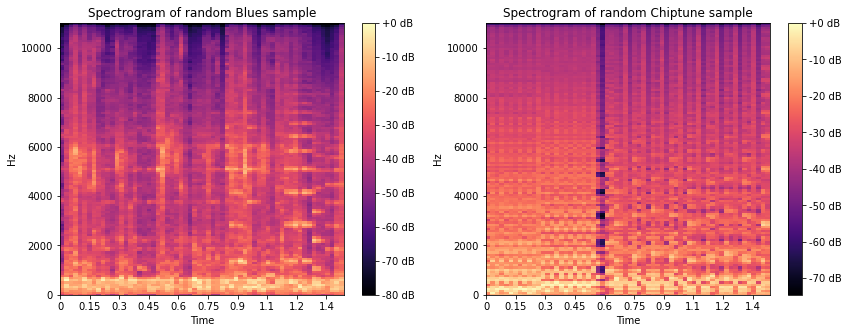

In [15]:
#Spectrogramms plots for beat synched data

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(mel_1_beat, x_axis='time', y_axis='linear', ax=ax1)
ax1.set(title=f'Spectrogram of random {lbl_1_beat} sample')
fig.colorbar(img, ax=ax1, format="%+2.f dB")


img = librosa.display.specshow(mel_2_beat, x_axis='time', y_axis='linear', ax=ax2)
ax2.set(title=f'Spectrogram of random {lbl_2_beat} sample')
fig.colorbar(img, ax=ax2, format="%+2.f dB")

Βλέπουμε πως τα δεδομένα είναι πιο "διακριτά" ως προς τον άξονα το χρόνουν το οποίο είναι αναμενόμενο ,ωστόσο βλέπουε οτι αν και εξαιρετικά λιγότερα δείγματα οι γραφικές μας δείχνουν παρόμοια πληροφορία.

#### Χρωμογραφήματα

Έχουμε ήδη κρατήσει απο προηγουμένως τις τιμές για χρωμογραφήματα καθώς διαβάζαμε το data.Τα χρονικά βήματα είναι ίδια όπως δείξαμε παραπάνω (και φαίνεται ξανα παρακάτω).Ωστόσο πλέον στις αντίστοιχες συχνότητες έχουμε 12 διαφορετικές νότες (ημιτόνια) (Παραπάνω πληροφορίες στην αναφορά).

In [16]:
print(chroma_1.shape)
print(chroma_1.shape)
print(chroma_1_beat.shape)  
print(chroma_1_beat.shape)  

(12, 1293)
(12, 1293)
(12, 62)
(12, 62)


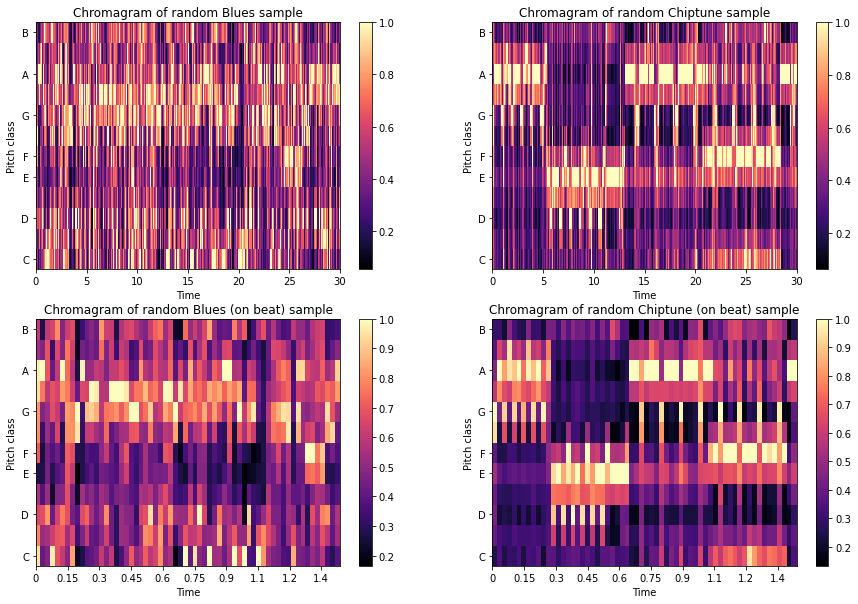

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))


img = librosa.display.specshow(chroma_1, y_axis='chroma', x_axis='time', ax=ax[0,0])
ax[0,0].set(title=f'Chromagram of random {lbl_1} sample')
fig.colorbar(img, ax=ax[0,0])

img = librosa.display.specshow(chroma_2, y_axis='chroma', x_axis='time', ax=ax[0,1])
ax[0,1].set(title=f'Chromagram of random {lbl_2} sample')
fig.colorbar(img, ax=ax[0,1])


img = librosa.display.specshow(chroma_1_beat, y_axis='chroma', x_axis='time', ax=ax[1,0])
ax[1,0].set(title=f'Chromagram of random {lbl_1_beat} (on beat) sample')
fig.colorbar(img, ax=ax[1,0])


img = librosa.display.specshow(chroma_2_beat, y_axis='chroma', x_axis='time', ax=ax[1,1])
ax[1,1].set(title=f'Chromagram of random {lbl_2_beat} (on beat) sample')
fig.colorbar(img, ax=ax[1,1])


### Βήμα 4

(b)

In [18]:
labels_for_hist=[i[1].split('\n')[0] for i in labels_beat[1:]]
class_counting = {
    'Rock': 0,
    'Psych-Rock': 0,
    'Indie-Rock':0,
    'Post-Rock': 0,
    'Psych-Folk': 0,
    'Folk': 0,
    'Metal': 0,
    'Punk': 0,
    'Post-Punk': 0,
    'Trip-Hop': 0,
    'Pop': 0,
    'Electronic': 0,
    'Hip-Hop': 0,
    'Classical': 0,
    'Blues': 0,
    'Chiptune': 0,
    'Jazz': 0,
    'Soundtrack': 0,
    'International':0,
    'Old-Time': 0
}

class_counting_after = {
    'Rock': 0,
    'Psych-Rock': 0,
    'Indie-Rock':0,
    'Post-Rock': 0,
    'Psych-Folk': 0,
    'Folk': 0,
    'Metal': 0,
    'Punk': 0,
    'Post-Punk': 0,
    'Trip-Hop': 0,
    'Pop': 0,
    'Electronic': 0,
    'Hip-Hop': 0,
    'Classical': 0,
    'Blues': 0,
    'Chiptune': 0,
    'Jazz': 0,
    'Soundtrack': 0,
    'International':0,
    'Old-Time': 0
}

class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

for label in labels_for_hist:
    class_counting[label]+=1


for label in labels_for_hist:
    if (class_mapping[label]==None):
        continue
    else:
        class_counting_after[class_mapping[label]]+=1


###  (c)

{'Rock': 160, 'Psych-Rock': 160, 'Indie-Rock': 160, 'Post-Rock': 95, 'Psych-Folk': 160, 'Folk': 160, 'Metal': 153, 'Punk': 160, 'Post-Punk': 160, 'Trip-Hop': 137, 'Pop': 160, 'Electronic': 160, 'Hip-Hop': 160, 'Classical': 160, 'Blues': 160, 'Chiptune': 160, 'Jazz': 160, 'Soundtrack': 124, 'International': 160, 'Old-Time': 160}


Text(0.5, 1.0, 'Genres before mapping')

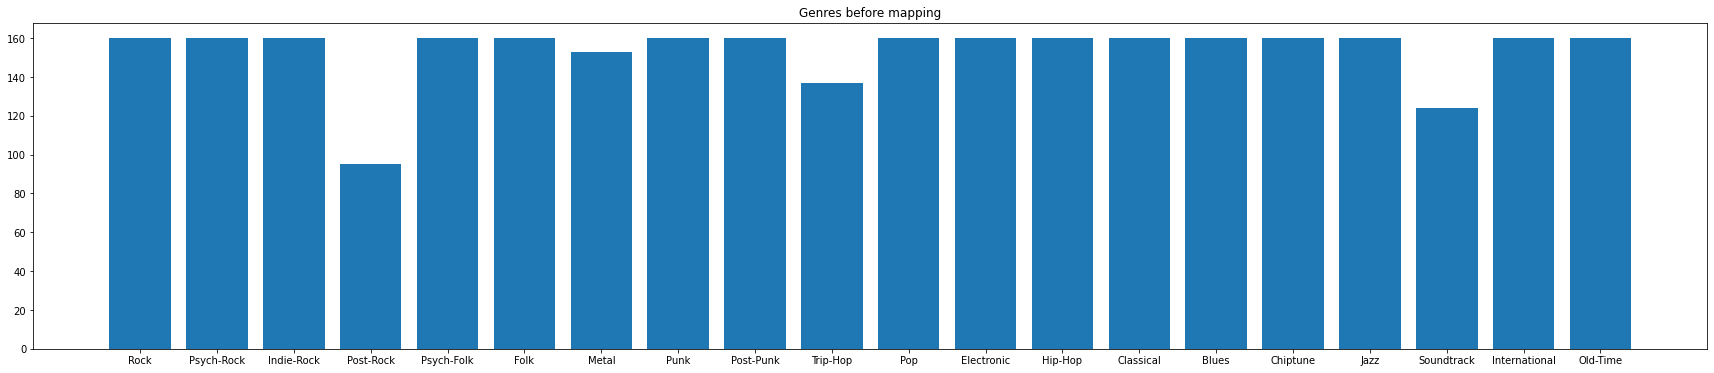

In [19]:
print(class_counting)

plt.figure(figsize=(30,6))
plt.bar(class_counting.keys(),class_counting.values())
plt.title("Genres before mapping")

{'Rock': 415, 'Psych-Rock': 0, 'Indie-Rock': 0, 'Post-Rock': 0, 'Psych-Folk': 0, 'Folk': 320, 'Metal': 313, 'Punk': 0, 'Post-Punk': 0, 'Trip-Hop': 137, 'Pop': 160, 'Electronic': 320, 'Hip-Hop': 160, 'Classical': 160, 'Blues': 160, 'Chiptune': 0, 'Jazz': 160, 'Soundtrack': 0, 'International': 0, 'Old-Time': 0}


Text(0.5, 1.0, 'Genres after mapping')

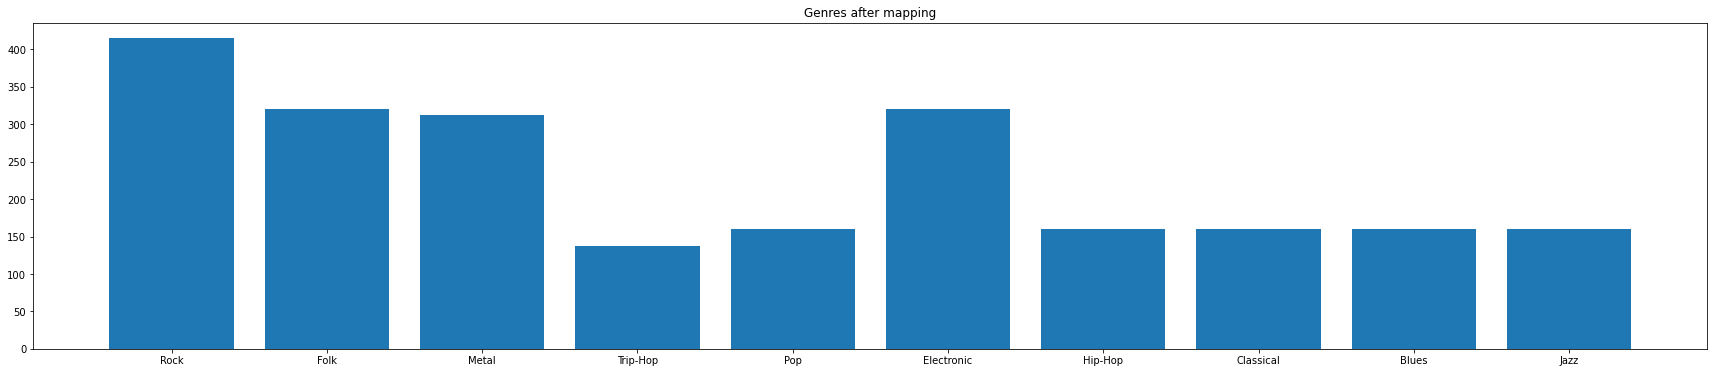

In [20]:
print(class_counting_after)

plt.figure(figsize=(30,6))
x_bar,y_bar=[],[]
for key in class_counting_after.keys():
    if (class_counting_after[key]==0):
        continue
    else:
        x_bar.append(key)
        y_bar.append(class_counting_after[key])
        
plt.bar(x_bar,y_bar)
plt.title("Genres after mapping")

In [21]:
# Import the necessary libraries
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

# Helper functions to read fused, mel, and chromagram
def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T

In [22]:
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?

#For experimenting seed gives us always the same split in train,val (or test) sets of the data.
#We should never use seed to train and optimize our NN because we are working with a specific split and not random and thus optimizing
#on the specific problem (split) we made. This will have as result bad generalization of our model!
def torch_train_val_split(dataset, batch_train, batch_eval,val_size=.2,test_size=.0, shuffle=True, seed=None,overfitt_test=False):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    if overfitt_test:
        dataset_size = 30
    
    #Get indexes for whole dataset
    indices = list(range(dataset_size))
    #Get number of indexes corresponding for validation set size
    val_split = int(np.floor(val_size * dataset_size))
    if test_size>0:
        #Get number of indexes corresponding for test set size (only for multitask problem and if test_size>0)
        test_split=int(np.floor(test_size * dataset_size))
    
    #Shuffle all the above indexes
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    #Get corresponding number of indices for validation set from the random shuffle
    train_indices = indices[val_split:]
    #Get corresponding number of indices (the rest of them) for train set from the random shuffle
    val_indices = indices[:val_split]
    
    if test_size>0:
        #Special case, get corresponding number of indices for train,validation and test set from the random shuffle
        train_indices = indices[test_split+val_split:]
        val_indices = indices[test_split:test_split+val_split]
        test_indices = indices[:test_split]

        
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    if test_size>0:
        test_sampler = SubsetRandomSampler(test_indices)
    
    #Creating Dataloaders for each set 
    
    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    
    if test_size>0:    
        test_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=test_sampler)
        
        return train_loader, val_loader,test_loader
    else:
        return train_loader, val_loader


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed (done in report)
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

# Pytorch Dataset Class for creating the dataset
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram,multi=(False,1),size=(1,1)):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping,multi)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        
        if t=='test' and size!=(1,1):
            tmp_list=[]            
            for f in self.feats:
                size_0=f.shape[0]
                target = np.zeros(size)
                target[:size_0,:]=f
                tmp_list.append(target)
            
            self.feats = tmp_list
        
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if multi[0]:
            self.labels=np.array(labels)    
        else:
            if isinstance(labels, (list, tuple)):
                self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping,multi):
        with open(txt, 'r') as fd:
            if multi[0]:
                lines = [l.rstrip().split('\t')[0].split(',') for l in fd.readlines()[1:]]
            else:
                lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []

        for l in lines:
            label = l[multi[1]]
            if multi[1]==4:
                label = [l[1],l[2],l[3]]    
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):        
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)


In [23]:
mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_mel , val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
     
ttest_loader_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram,size=(1293,128))

test_loader_mel, _ = torch_train_val_split(ttest_loader_mel, 32 ,32, val_size=0)

#Small Dataloader for training until overfitt to check that our NN works properly
train_loader_mel_overfitt, _ = torch_train_val_split(mel_specs, 32 ,32, val_size=0.99)

In [24]:
#Get batch
datum_dataloader = next(iter(mel_specs))
print(datum_dataloader)
print(len(datum_dataloader[0]))

(array([[-43.83311129, -38.70563043, -38.35403122, ..., -80.        ,
        -80.        , -80.        ],
       [-38.12250853, -33.27389471, -27.27369542, ..., -76.01939964,
        -80.        , -80.        ],
       [-41.59139609, -29.96261656, -19.7837484 , ..., -72.64204372,
        -80.        , -80.        ],
       ...,
       [-31.94057632, -30.6798495 , -18.57387826, ..., -60.7489931 ,
        -66.71647555, -74.9795387 ],
       [-34.06573274, -29.59102852, -20.84280373, ..., -59.0818695 ,
        -61.45574029, -65.87385741],
       [-41.04537492, -27.96117793, -23.22100798, ..., -55.24135367,
        -56.17455526, -58.91387911]]), 0, 1293)
1293


Επιστρέφετε τα δεδομένα για ένα δείγμα,το label του καθώς και το μέγεθος (χρονικά βήματα). 

In [25]:
#Get batch
datum = next(iter(train_loader_mel))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([32, 1293, 128])
Labels
tensor([6, 3, 8, 9, 8, 0, 6, 1, 8, 3, 9, 9, 2, 6, 8, 8, 6, 8, 2, 7, 6, 8, 2, 7,
        9, 7, 3, 9, 4, 2, 6, 9])
Lengths
tensor([1291, 1291, 1293, 1292, 1293, 1291, 1293, 1291, 1291, 1293, 1291, 1291,
        1291, 1292, 1293, 1291, 1291, 1293, 1293, 1293, 1291, 1291, 1291, 1291,
        1292, 1291, 1291, 1291, 1292, 1291, 1291, 1291])


In [26]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from time import time
import torch
import torch.tensor as tensor
import torch.nn as nn 
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report

In [27]:
#For GPU usage
global DEVICE
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [28]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False,dropout = 0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.layers = num_layers
        self.hidden_size = rnn_size
        device=DEVICE
        self.lstm = nn.LSTM(input_size=input_dim,hidden_size=rnn_size,num_layers=num_layers,dropout=dropout,bidirectional=bidirectional,batch_first=True).to(device)
        
        
        self.clf = nn.Linear(in_features=self.feature_size,out_features=output_dim).to(device)
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
    def forward(self, x, lengths):
        """
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        DEVICE = self.DEVICE

        # Initial Hidden State h_0
        if self.bidirectional:
            h_0 = torch.zeros(self.layers*2,len(x),self.hidden_size).to(DEVICE).double()
            # Initial Cell State c_0 (same as h_0)
            c_0 = torch.zeros(self.layers*2,len(x),self.hidden_size).to(DEVICE).double()
        else:
            h_0 = torch.zeros(self.layers,len(x),self.hidden_size).to(DEVICE).double()
            # Initial Cell State c_0 (same as h_0)
            c_0 = torch.zeros(self.layers,len(x),self.hidden_size).to(DEVICE).double()
        
        lstm_out,_ = self.lstm(x.double(),(h_0,c_0))
        last_outputs = self.clf(self.last_timestep(lstm_out,lengths,bidirectional=self.bidirectional))
        
        return last_outputs
    
    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)
    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward
    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx.long()).squeeze()

In [29]:
from torch.optim import SGD,Adam,SparseAdam,ASGD
from time import time 
import copy
device=DEVICE
def fit_lstm(model,epochs,lr,t_loader,v_loader,val=True,DEVICE=torch.device('cpu')):
    # Create model and convert to a cuda compatible oject
    model = model.double().to(DEVICE)
    
    to_print=1
    if epochs>100:
        to_print=50
    if epochs>700:
        to_print=100
    
    val_losses = []
    train_losses = []

    # Initialization of loss function and optimizer 
    loss_fun = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr=lr)

    for epoch in range(epochs):
        ep_loss = 0             
        # Iterate over batches of the Train Dataset
        model.train()

        for batch in t_loader:
            X,labels,lengths=batch
#             model.zero_grad()
            optimizer.zero_grad()

            out = model(X.to(DEVICE),lengths.to(DEVICE)).to(DEVICE)

            loss = loss_fun(out,labels.to(DEVICE))
            loss.backward()

            optimizer.step()

            ep_loss += loss.data.item()

        train_losses.append(ep_loss/len(t_loader))

        if epoch%to_print == 0:
            print(f'Epoch {epoch+1} : Train loss is {ep_loss/len(t_loader)}')

        model.eval()

        if val :
            with torch.no_grad():
                validation_loss = 0 
                # Iterate over validation set in batches, to check to validation loss
                for i,batch in enumerate(v_loader) :
                    X,labels,lengths=batch

                    out_val = model(X.to(device),lengths.to(device)).to(DEVICE)

                    loss  = loss_fun(out_val.to(DEVICE),labels.to(DEVICE))

                    validation_loss+=loss.data.item()

                val_losses.append(validation_loss/len(v_loader))
                
                if epoch%to_print == 0:
                    print(f'Epoch {epoch+1} : Validation Loss is {validation_loss/len(v_loader)}')
                    print('-'*80)
                    
    if val:
        return model ,train_losses,val_losses
    else :
        return model,train_losses

In [30]:
# Definition of a function that calculates the accuracy of a model 
def score_lstm(model,loader,DEVICE=torch.device('cpu')) :
    preds = []
    y_test = []
    for i,batch in enumerate(loader,1) :
        X,labels,lengths=batch        
        X.to(DEVICE)
        with torch.no_grad():
            
            out = model(X.to(DEVICE).double(),lengths.to(DEVICE)).to(DEVICE)
        if X.size()[0] !=1 :
            for y_pred,label in zip(out,labels) :
                tmp = torch.argmax(y_pred)
                preds.append(tmp.item())
                y_test.append(label)
        else :
            y_pred = torch.argmax(out).item()
            preds.append(y_pred)
            y_test.append(labels)
    return accuracy_score(preds,y_test),np.array(preds),np.array(y_test)

In [31]:
model_overfitt = BasicLSTM(128, 16, 10, 1, bidirectional=True)

In [32]:
start=time()
out = fit_lstm(model_overfitt,epochs=1000,lr=0.001,t_loader=train_loader_mel_overfitt,v_loader=val_loader_mel,val=False,DEVICE=DEVICE)
print(f"Model trained in :{np.round(time()-start,3)}")

Epoch 1 : Train loss is 2.329036058676604
Epoch 101 : Train loss is 1.81062112130745
Epoch 201 : Train loss is 1.52985882306216
Epoch 301 : Train loss is 1.302999755960207
Epoch 401 : Train loss is 1.2060706785269106
Epoch 501 : Train loss is 0.9584657795484407
Epoch 601 : Train loss is 0.8191918063826655
Epoch 701 : Train loss is 0.7164349165489936
Epoch 801 : Train loss is 0.6265082582936331
Epoch 901 : Train loss is 0.5568028530760377
Model trained in :99.175


In [33]:
torch.save(model_overfitt, './mel_overfitt')
# model_overfitt=torch.load('../input/models-trained/mel_overfitt',map_location=torch.device('cpu'))


In [34]:
print(f"Overfitt proof is :{score_lstm(model_overfitt,train_loader_mel_overfitt,DEVICE)}")

Overfitt proof is :(0.9166666666666666, array([6, 2, 8, 5, 8, 2, 3, 2, 3, 6, 2, 5, 1, 2, 3, 6, 2, 0, 2, 2, 2, 6,
       9, 7]), array([6, 2, 8, 5, 8, 2, 3, 2, 3, 6, 2, 5, 1, 2, 3, 6, 4, 0, 1, 2, 2, 6,
       9, 7]))


Το μοντέλο μας όπου φαίνεται παραπάνω όντως οδηγήθηκε σε overfitting συνεπώς υπάρχει εκπαίδευση.

#### Mel dataset

In [35]:
start=time()
model_mel = BasicLSTM(128, 16, 10, 1, bidirectional=True)
out = fit_lstm(model_mel,epochs=400,lr=0.001,t_loader=train_loader_mel,v_loader=val_loader_mel,val=True,DEVICE=DEVICE)
print(f"Model trained in :{np.round(time()-start,3)} s")

Epoch 1 : Train loss is 2.2397802231649537
Epoch 1 : Validation Loss is 2.2386153381297476
--------------------------------------------------------------------------------
Epoch 51 : Train loss is 2.21465534304081
Epoch 51 : Validation Loss is 2.2356432586767343
--------------------------------------------------------------------------------
Epoch 101 : Train loss is 2.215968642406997
Epoch 101 : Validation Loss is 2.2358984786354985
--------------------------------------------------------------------------------
Epoch 151 : Train loss is 2.2134841937892786
Epoch 151 : Validation Loss is 2.233723314662695
--------------------------------------------------------------------------------
Epoch 201 : Train loss is 2.2083733941455947
Epoch 201 : Validation Loss is 2.2281514989200084
--------------------------------------------------------------------------------
Epoch 251 : Train loss is 2.210720004871284
Epoch 251 : Validation Loss is 2.2272856380450308
------------------------------------

In [36]:
torch.save(model_overfitt, './mel_rnn_32_ep_400_lr_001')

In [37]:
score,y_test_pred,y_test=score_lstm(model_mel,test_loader_mel,DEVICE)
print(f"FMA spectrogramms score is :{score} \n")
print(classification_report(y_test, y_test_pred))

FMA spectrogramms score is :0.1582608695652174 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.25      0.03      0.05        40
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.13      0.60      0.21        78
           7       0.00      0.00      0.00        40
           8       0.21      0.42      0.28       103
           9       0.00      0.00      0.00        34

    accuracy                           0.16       575
   macro avg       0.06      0.10      0.05       575
weighted avg       0.07      0.16      0.08       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
beat_mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
     
ttest_loader_beat_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)

test_loader_beat_mel, _ = torch_train_val_split(ttest_loader_beat_mel, 32 ,32, val_size=0)


#### Mel beat-synced dataset

In [39]:
start=time()
model_mel_beat = BasicLSTM(128, 16, 10, 1, bidirectional=True)
out = fit_lstm(model_mel_beat,epochs=500,lr=0.001,t_loader=train_loader_beat_mel,v_loader=val_loader_beat_mel,val=True,DEVICE=DEVICE)
print(f"Model (beat synced) trained in :{np.round(time()-start,3)} s")

Epoch 1 : Train loss is 2.2718433810320877
Epoch 1 : Validation Loss is 2.217277247259341
--------------------------------------------------------------------------------
Epoch 51 : Train loss is 2.0453385615062336
Epoch 51 : Validation Loss is 2.0419403588149856
--------------------------------------------------------------------------------
Epoch 101 : Train loss is 2.0190494199006
Epoch 101 : Validation Loss is 1.9868466107302254
--------------------------------------------------------------------------------
Epoch 151 : Train loss is 2.0259204302049016
Epoch 151 : Validation Loss is 1.9622416769635977
--------------------------------------------------------------------------------
Epoch 201 : Train loss is 1.9747486383108588
Epoch 201 : Validation Loss is 1.9612791437595982
--------------------------------------------------------------------------------
Epoch 251 : Train loss is 1.9597402567333155
Epoch 251 : Validation Loss is 1.9604905500725043
-----------------------------------

Παρατηρούμε πως η εκπαίδευση γίνεται εξαιρετικά πιο γρήγορα σε σχέση με προηγουμένως. Το οποίο ήταν αναμενόμενο καθώς έχουμε πολύ λιγότερες διαστάσεις.

In [40]:
torch.save(model_mel_beat, './mel_beat_rnn_32_ep_500_lr_001')

In [41]:
score,y_test_pred,y_test=score_lstm(model_mel_beat,test_loader_beat_mel,DEVICE)
print(f"FMA spectrogramms Beat synced score is :{score} \n")
print(classification_report(y_test, y_test_pred))

FMA spectrogramms Beat synced score is :0.2921739130434783 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.28      0.68      0.40        80
           3       0.26      0.60      0.36        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.32      0.15      0.21        78
           7       0.00      0.00      0.00        40
           8       0.34      0.52      0.42       103
           9       0.00      0.00      0.00        34

    accuracy                           0.29       575
   macro avg       0.12      0.20      0.14       575
weighted avg       0.18      0.29      0.21       575



In [42]:
beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
    
train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32 ,32, val_size=.33)
     
ttest_loader_beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

test_loader_beat_chroma, _ = torch_train_val_split(ttest_loader_beat_chroma, 32 ,32, val_size=0)


#### Chroma beat-synced dataset

In [43]:
start=time()
model_chroma_beat = BasicLSTM(12, 16, 10, 1, bidirectional=True)
out = fit_lstm(model_chroma_beat,epochs=400,lr=0.001,t_loader=train_loader_beat_chroma,v_loader=val_loader_beat_chroma,val=True,DEVICE=DEVICE)
print(f"Model (beat synced) trained in :{np.round(time()-start,3)} s")

Epoch 1 : Train loss is 2.2656949321400273
Epoch 1 : Validation Loss is 2.223476441246245
--------------------------------------------------------------------------------
Epoch 51 : Train loss is 2.061887811306681
Epoch 51 : Validation Loss is 2.175244338222281
--------------------------------------------------------------------------------
Epoch 101 : Train loss is 1.9924729630006548
Epoch 101 : Validation Loss is 2.2087890614172934
--------------------------------------------------------------------------------
Epoch 151 : Train loss is 1.9237729411525277
Epoch 151 : Validation Loss is 2.2428477239681768
--------------------------------------------------------------------------------
Epoch 201 : Train loss is 1.8525774966164792
Epoch 201 : Validation Loss is 2.3114748466666346
--------------------------------------------------------------------------------
Epoch 251 : Train loss is 1.6643257666136793
Epoch 251 : Validation Loss is 2.3913669564579396
----------------------------------

In [44]:
torch.save(model_chroma_beat, './chroma_beat_rnn_32_ep_400_lr_001')

In [45]:
score,y_test_pred,y_test=score_lstm(model_chroma_beat,test_loader_beat_chroma,DEVICE)
print(f"FMA Chromogramm (beat synced) score is :{score}")
print(classification_report(y_test, y_test_pred))

FMA Chromogramm (beat synced) score is :0.2
              precision    recall  f1-score   support

           0       0.07      0.05      0.06        40
           1       0.19      0.20      0.19        40
           2       0.19      0.17      0.18        80
           3       0.25      0.33      0.28        80
           4       0.14      0.05      0.07        40
           5       0.05      0.03      0.03        40
           6       0.28      0.35      0.31        78
           7       0.03      0.03      0.03        40
           8       0.23      0.33      0.27       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.14      0.15      0.14       575
weighted avg       0.17      0.20      0.18       575



In [46]:
specs_fused_beat = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader_beat, val_loader_beat = torch_train_val_split(specs_fused_beat, 32 ,32, val_size=.33)

ttest_loader_beat = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)


test_loader_beat, _ = torch_train_val_split(ttest_loader_beat, 32 ,32, val_size=0)


#### Fused (mel & chroma) beat-synced dataset 

In [47]:
start=time()
model_fused_beat = BasicLSTM(12+128, 16, 10, 1, bidirectional=True)
out = fit_lstm(model_fused_beat,epochs=400,lr=0.001,t_loader=train_loader_beat,v_loader=val_loader_beat,val=True,DEVICE=DEVICE)
print(f"Model (beat synced) trained in :{np.round(time()-start,3)} s")

Epoch 1 : Train loss is 2.2274370459292543
Epoch 1 : Validation Loss is 2.2156511807788513
--------------------------------------------------------------------------------
Epoch 51 : Train loss is 2.222035871938233
Epoch 51 : Validation Loss is 2.2255460374464215
--------------------------------------------------------------------------------
Epoch 101 : Train loss is 2.2229765186969064
Epoch 101 : Validation Loss is 2.224264528464018
--------------------------------------------------------------------------------
Epoch 151 : Train loss is 2.222745238552927
Epoch 151 : Validation Loss is 2.2259372408572076
--------------------------------------------------------------------------------
Epoch 201 : Train loss is 2.2268484016384424
Epoch 201 : Validation Loss is 2.2248234345410673
--------------------------------------------------------------------------------
Epoch 251 : Train loss is 2.2215318799355606
Epoch 251 : Validation Loss is 2.224997839743398
-----------------------------------

In [48]:
torch.save(model_fused_beat, './fused_beat_rnn_32_ep_400_lr_001')

In [49]:
score,y_test_pred,y_test=score_lstm(model_fused_beat,test_loader_beat,DEVICE)
print(f"Fused (beat synch) score is :{score}")
print(classification_report(y_test, y_test_pred))

Fused (beat synch) score is :0.1791304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.18      1.00      0.30       103
           9       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



#### Fused dataset 

In [50]:
specs_fused = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)

ttest_loader = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)


test_loader, _ = torch_train_val_split(ttest_loader, 32 ,32, val_size=0)


In [51]:
start=time()
model_fused = BasicLSTM(12+128, 16, 10, 2, bidirectional=True)
out = fit_lstm(model_fused,epochs=500,lr=0.001,t_loader=train_loader,v_loader=val_loader,val=True,DEVICE=DEVICE)
print(f"Model trained in :{np.round(time()-start,3)} s")

Epoch 1 : Train loss is 2.2506457576895835
Epoch 1 : Validation Loss is 2.2229472960407883
--------------------------------------------------------------------------------
Epoch 51 : Train loss is 2.0403934278855966
Epoch 51 : Validation Loss is 2.034771083676947
--------------------------------------------------------------------------------
Epoch 101 : Train loss is 1.9528673563661416
Epoch 101 : Validation Loss is 1.972277867134139
--------------------------------------------------------------------------------
Epoch 151 : Train loss is 2.220921664342708
Epoch 151 : Validation Loss is 2.227251910925439
--------------------------------------------------------------------------------
Epoch 201 : Train loss is 2.2152986724438586
Epoch 201 : Validation Loss is 2.2293497295960853
--------------------------------------------------------------------------------
Epoch 251 : Train loss is 2.211828227614528
Epoch 251 : Validation Loss is 2.220736790289408
-------------------------------------

In [52]:
torch.save(model_fused, './fused_rnn_32_ep_400_lr_001')

In [53]:
score,y_test_pred,y_test=score_lstm(model_fused,test_loader,DEVICE)
print(f"Fused score is :{score}")
print(classification_report(y_test, y_test_pred))

Fused score is :0.16869565217391305
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.16      0.50      0.24        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.17      0.55      0.27       103
           9       0.00      0.00      0.00        34

    accuracy                           0.17       575
   macro avg       0.03      0.11      0.05       575
weighted avg       0.05      0.17      0.08       575

